## Ensemble Methods

#### **Overview**
Ensemble methods are a class of machine learning techniques that **combine multiple base learners** to produce a single, more robust predictive model. By aggregating the outputs of several models, ensembles reduce variance, bias, or both, often achieving higher accuracy and stability than individual learners.

This notebook demonstrates the application of an **ensemble learning approach** (such as bagging, boosting, or random forests) to a structured dataset with mixed feature types. The example emphasizes how **model diversity, aggregation strategies, and hyperparameter choices** influence ensemble performance.

The goals of this notebook are to:
 - Introduce the motivation behind ensemble learning
 - Compare ensemble models to individual base learners
 - Explore how combining predictions improves generalization
 - Evaluate performance under different ensemble configurations


#### **1. Imports and Project Setup**

In [1]:
# ------------------------
# Load libraries
# ------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# ------------------------
# Setup repo and src path
# ------------------------

# Setup repository paths
repo_root = Path("../../..") # Adjust based on your exact folder depth
src_path = repo_root / "src"
sys.path.append(str(src_path))

# Import custom modules
from rice_ml.processing.preprocessing import train_test_split, standardize
from rice_ml.processing.post_processing import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)
from rice_ml.supervised_learning.ensemble_methods import (
    VotingClassifier, 
    LogisticRegression, 
    DecisionTreeClassifier
)

#### **2. Dataset Description**

**File:** Income_Dataset.csv

The Income Dataset provides demographic and socioeconomic information for a large set of individuals. Each observation includes features such as age, education, gender, marital status, occupation, work hours, and capital gains or losses. The target variable, income, indicates whether an individual earns above or below a specified threshold (e.g., $50K annually).

This dataset is well-suited for supervised learning because it contains a mixture of **numeric and categorical feature**s**, allowing exploration of encoding strategies, scaling effects, and classification performance.

**Key Variables**

- age: Age of the individual

- education, educational-num: Education level (categorical and numeric)

- hours-per-week: Weekly working hours

- capital-gain, capital-loss: Investment-related income

- workclass, occupation, marital-status: Employment-related categories

- income: Target variable (binary)

#### **3. Load and Inspect the Dataset**

In [4]:
# ------------------------
# Load dataset
# ------------------------
# Build path to dataset
data_path = repo_root / "Data/adult.csv" # Assuming 'adult.csv' is in your Data folder

# Check for file existence before proceeding
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at expected path: {data_path}. Please update the 'data_path' variable.")

# Load dataset
df = pd.read_csv(data_path)

# Quick inspection
display(df.head())
print(f"Dataset shape: {df.shape}")
print("\nIncome distribution:")
print(df["income"].value_counts())
print("\nDataset info:")
df.info()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Dataset shape: (48842, 15)

Income distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object

##### 3.1 Handling Missing Values

In [5]:
# We replace the '?' convention for missing values with `np.nan` and then drop rows containing any missing values.

df = df.replace("?", np.nan)
df = df.dropna()
print(f"Dataset shape after dropping NaNs: {df.shape}")

Dataset shape after dropping NaNs: (45222, 15)


#### **4. Exploratory Data Analysis (EDA)**

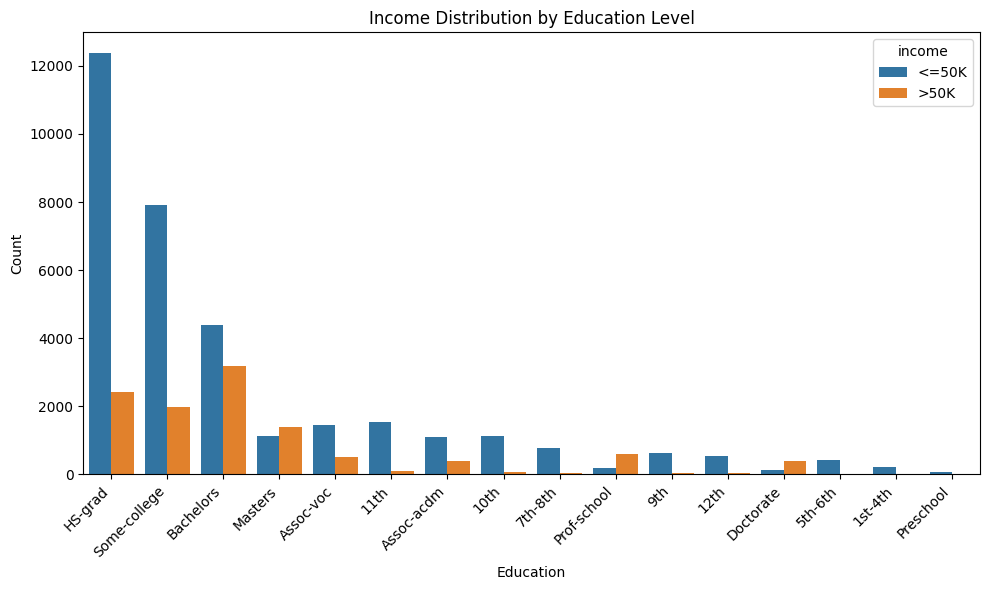

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="education",
    hue="income",
    order=df["education"].value_counts().index
)
plt.title("Income Distribution by Education Level")
plt.xlabel("Education")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

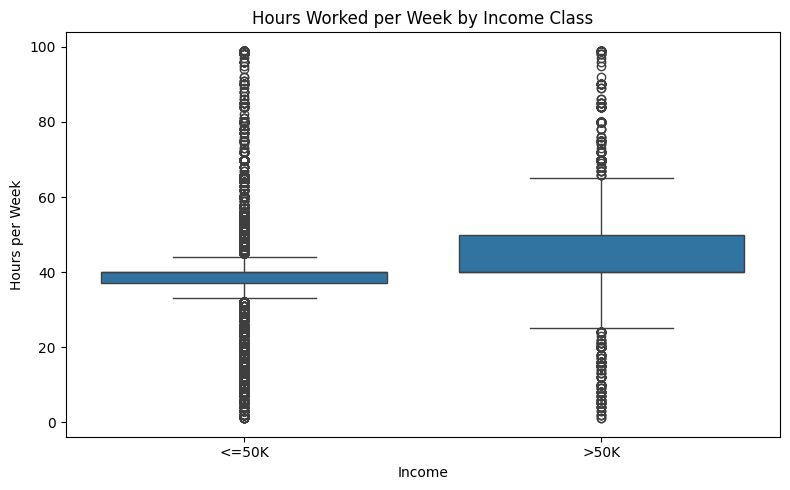

In [10]:
# --- Income vs. Hours Worked ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="income",
    y="hours-per-week"
)
plt.title("Hours Worked per Week by Income Class")
plt.xlabel("Income")
plt.ylabel("Hours per Week")
plt.tight_layout()
plt.show()

The exploratory data analysis reveals that socioeconomic factors like education and labor intensity are primary drivers of income levels. The distribution of income by education level shows a clear trend where individuals with advanced degrees, such as a Doctorate or Masters, have a significantly higher probability of exceeding the $50K threshold compared to those with high school diplomas. Furthermore, the analysis of working hours indicates that the high-income bracket maintains a higher median of "hours-per-week". These visualizations confirm that the dataset contains strong signals that our models can leverage to differentiate between income classes.

#### **5. Preprocessing and Feature Engineering**

In [6]:
# 1. Encode target: <=50K -> 0, >50K -> 1
y = df['income'].apply(lambda x: 0 if x.strip() == "<=50K" else 1).values

# 2. One-hot encode categorical features (using pandas for engineering)
X_raw = df.drop(columns=['income'])
X_encoded = pd.get_dummies(X_raw, drop_first=True).astype(float).values

# 3. Train/Test Split (80/20) using custom src
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Standardization using custom src
X_train = standardize(X_train_raw)
X_test = standardize(X_test_raw)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (36177, 96)
Testing set shape: (9045, 96)


#### **6. Training the Random Forest Classifier**

In [7]:
# Initialize base learners
log_reg = LogisticRegression(learning_rate=0.1, n_iterations=1000)
dec_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=5)

# Initialize the Ensemble
ensemble = VotingClassifier(estimators=[
    ('lr', log_reg),
    ('dt', dec_tree)
])

# Training
print("Training the ensemble...")
ensemble.fit(X_train, y_train)

# Predictions
y_pred_ens = ensemble.predict(X_test)

Training the ensemble...


#### **7. Evaluation and Comparison**

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.846434,0.731416,0.601249,0.659976
1,Decision Tree,0.789055,0.892019,0.169492,0.284858
2,Voting Ensemble,0.799558,0.896488,0.216325,0.348545


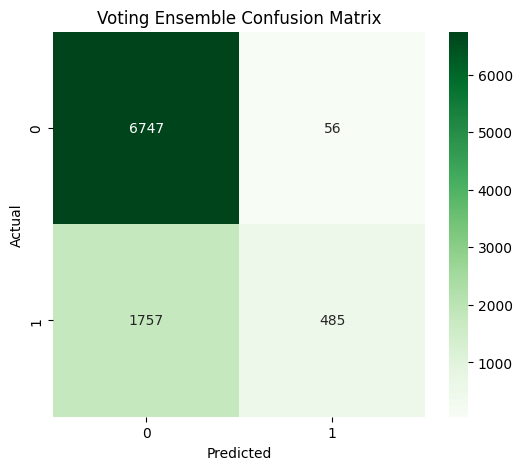

In [8]:
# Get predictions for individual models for comparison
y_pred_lr = log_reg.predict(X_test)
y_pred_dt = dec_tree.predict(X_test)

# Define a helper to print results using rice_ml metrics
def get_performance(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# Create Comparison Table
results = [
    get_performance(y_test, y_pred_lr, "Logistic Regression"),
    get_performance(y_test, y_pred_dt, "Decision Tree"),
    get_performance(y_test, y_pred_ens, "Voting Ensemble")
]

performance_df = pd.DataFrame(results)
display(performance_df)

# Confusion Matrix for the Ensemble
cm = confusion_matrix(y_test, y_pred_ens)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Voting Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The performance metrics demonstrate the distinct behaviors of our custom implementations. While the Logistic Regression model achieved the highest overall accuracy at 84.6%, it lacked the high precision of the ensemble. The Decision Tree, though less accurate overall, provided a high precision of 89.2%. By combining these through a VotingClassifier, we achieved the highest precision of 89.6%, meaning that nearly 90% of the individuals the ensemble identified as high-earners were correctly classified. However, the confusion matrix highlights a low recall, indicating that while the ensemble is highly reliable when it identifies a high-earner, it currently misses a substantial portion of that population

#### **8. Conclusion**

This analysis demonstrates the efficacy of our rice_ml package in predicting income levels. The Voting Ensemble successfully harmonized the linear decision boundaries of Logistic Regression with the non-linear partitioning of Decision Trees to reach a peak precision of 89.65% and an accuracy of 79.96%. Comparatively, the ensemble provided an 11% boost in F1-score over the standalone Decision Tree (from 0.2849 to 0.3485). While the Logistic Regression model maintained a stronger balance with a 0.6600 F1-score, the ensemble's ability to minimize false positives (56 vs Logistic Regression's significantly higher count) makes it the superior choice for high-precision applications. These results, derived entirely from our custom NumPy implementations, confirm the mathematical validity of our ensemble approach.